In [13]:
%run ../00_AdvancedPythonConcepts/talktools.py

# Gaussian Processes

"A Gaussian process is a generalization of the
Gaussian probability distribution. Whereas a probability distribution describes
random variables which are scalars or vectors (for multivariate distributions),
a stochastic process governs the properties of functions. Leaving mathematical
sophistication aside, one can loosely think of a function as a very long vector,
each entry in the vector specifying the function value f(x) at a particular input
x"

<img src="http://www.gaussianprocess.org/gpml/rwcover.gif">
http://www.gaussianprocess.org/

(see also http://katbailey.github.io/post/gaussian-processes-for-dummies/, https://github.com/adamian/adamian.github.io/blob/master/talks/Damianou_16_MIT.pdf)

Following http://keyonvafa.com/gp-tutorial/: 

"GP is specified by a mean function $m(x)$ and a covariance function $k(x,x′)$, otherwise known as a kernel. That is, for any $x,x′$, $m(x)=𝔼[f(x)]$ and $k(x,x′)=Cov(f(x),f(x′))$."
 
say
$$
k(x,x′)=h^2 \left(1+\frac{(x−x′)^2}{2αl^2}\right)^{−α},
$$
we can plot some functions (for $h=1$ and $m(x) = 0$):

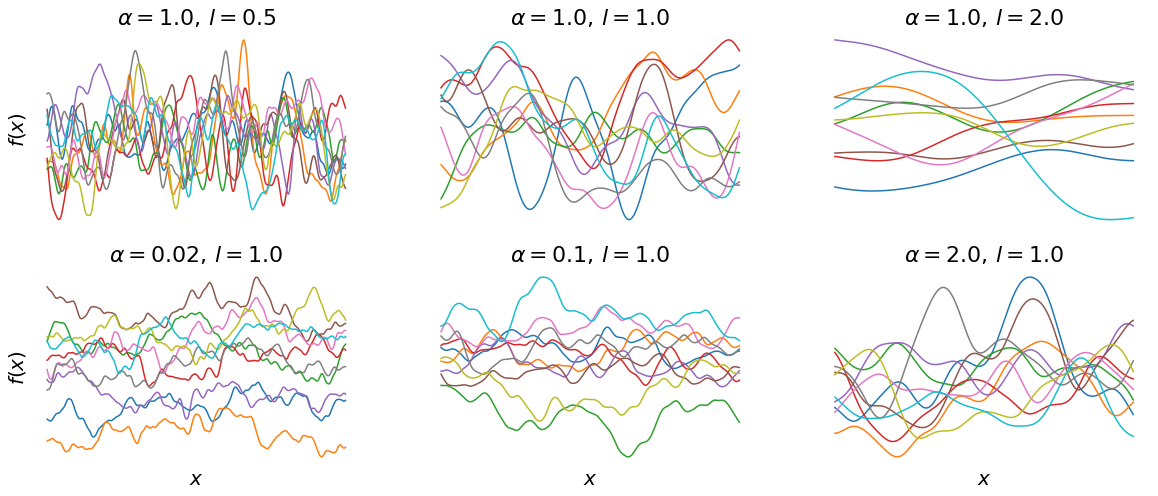

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def rq_covariance(params, x, xp):
    h= params[0]
    alpha = params[1]
    l = params[2]
    diffs = np.expand_dims(x /l, 1) - np.expand_dims(xp/l, 0)
    return h**2 *np.power(1+np.sum(diffs**2, axis=2)/(2*alpha*l**2),(-1*alpha)) 

def plot_gp(ax,params,plot_xs,n_samples = 10,xlab=False,ylab=False):
    plot_xs = np.reshape(np.linspace(-5, 5, 300), (300,1))
    sampled_funcs = np.random.multivariate_normal(np.ones(len(plot_xs)), rq_covariance(params,plot_xs,plot_xs),\
    					size=10)
    ax.plot(plot_xs, sampled_funcs.T)
    ax.set_title(r'$\alpha = {},\/ l = {} $'.format(\
        params[1],params[2]),fontsize = 22)
    if xlab:
        ax.set_xlabel(r'$x$',fontsize = 20)
    if ylab:
        ax.set_ylabel(r'$f(x)$',fontsize = 20)

fig = plt.figure(figsize=(20,8), facecolor='white')
ax_1 = fig.add_subplot(231, frameon=False)
ax_2 = fig.add_subplot(232, frameon=False)
ax_3 = fig.add_subplot(233, frameon=False)
ax_4 = fig.add_subplot(234, frameon=False)
ax_5 = fig.add_subplot(235, frameon=False)
ax_6 = fig.add_subplot(236, frameon=False)
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_2.set_xticks([])
ax_2.set_yticks([])
ax_3.set_xticks([])
ax_3.set_yticks([])
ax_4.set_xticks([])
ax_4.set_yticks([])
ax_5.set_xticks([])
ax_5.set_yticks([])
ax_6.set_xticks([])
ax_6.set_yticks([])

plot_xs = np.reshape(np.linspace(-5, 5, 300), (300,1))
plot_gp(ax_1,np.array([1,1,.5]),plot_xs,ylab=True)
plot_gp(ax_2,np.array([1,1,1.0]),plot_xs)
plot_gp(ax_3,np.array([1,1,2.0]),plot_xs)
plot_gp(ax_4,np.array([1,.02,1]),plot_xs,ylab=True,xlab=True)
plot_gp(ax_5,np.array([1,.1,1]),plot_xs,xlab=True)
plot_gp(ax_6,np.array([1,2.0,1]),plot_xs,xlab=True)

By measuring value of $f(x)$ for some finite $x$ we can pin down viable values of possible functions that are consitent with the data.

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel as C

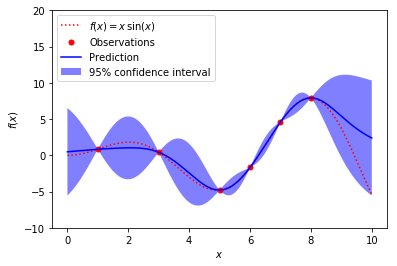

In [17]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.5,alpha=1.5)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

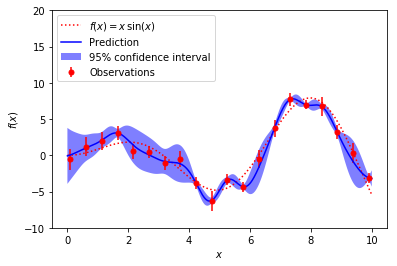

In [20]:
# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=0.5,alpha=0.5)


# Instanciate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')